## Imports

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna
import warnings
warnings.filterwarnings('ignore')

## File location update

In [7]:
head, tail = os.path.split(os.getcwd())
os.chdir(os.path.join(head,'01_Data'))

## Helper Function

### RMSE

In [8]:
def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

### Select Features

In [9]:
def select_features(X, y, top_n=30, is_classifier=False):
    """Select top features based on LightGBM feature importance"""
    # Initial model with default hyperparameters
    if is_classifier:
        model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    else:
        model = lgb.LGBMRegressor(objective="regression", n_estimators=100, random_state=42)
    
    # Fit model
    model.fit(X, y)
    
    # Get feature importances
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Return top N features
    top_features = importances.head(top_n)['feature'].tolist()
    print(f"Selected {len(top_features)} features based on importance")
    print(f"Top 5 features: {', '.join(top_features[:5])}")
    
    return X[top_features]

### Tune Model

In [52]:
def tune_all_models(train_data, val_data, n_trials=5, time_limit=180):
    """
    Efficiently tune all models in one function with time constraints
    
    Parameters:
    -----------
    train_data : dict
        Dictionary with training data for each model
    val_data : dict
        Dictionary with validation data for each model
    n_trials : int
        Maximum number of trials for each optimization
    time_limit : int
        Maximum seconds per model tuning
        
    Returns:
    --------
    dict
        Dictionary with optimized parameters for each model
    """
    def objective_factory(X_train, y_train, X_val, y_val, model_type):
        """Create an objective function for a specific model type"""
        
        def objective(trial):
            # Common parameters for all models
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
                "n_estimators": 5000,  # Use early stopping
                "num_leaves": trial.suggest_int("num_leaves", 20, 150),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 1.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 1.0, log=True),
                "random_state": 42
            }
            
            is_classifier = model_type.endswith('_cls')
            
            # Different model and evaluation metrics for classification vs regression
            if is_classifier:
                params["objective"] = "binary"
                model = lgb.LGBMClassifier(**params)
                eval_metric = "auc"
            else:
                params["objective"] = "regression" 
                model = lgb.LGBMRegressor(**params)
                eval_metric = "rmse"
            
            # Early stopping callback
            callbacks = [lgb.early_stopping(50, verbose=False)]
            
            # Train model
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric=eval_metric,
                callbacks=callbacks,
                verbose=False
            )
            
            # Get the best metric value
            if is_classifier:
                # For classification, we want to maximize AUC
                y_pred = model.predict_proba(X_val)[:, 1]
                score = roc_auc_score(y_val, y_pred)
                return score
            else:
                # For regression, we want to minimize RMSE 
                # (but Optuna maximizes, so we return negative RMSE)
                y_pred = model.predict(X_val)
                score = -rmse(y_val, y_pred)
                return score
                
        return objective
    
    # Results dictionary
    results = {}
    
    # Define the models to tune
    models = {
        'cs': {'is_classifier': True},
        'lc_cls': {'is_classifier': True},
        'lc_reg': {'is_classifier': False},
        'halc_cls': {'is_classifier': True},
        'halc_reg': {'is_classifier': False}
    }
    
    # Tune each model
    for model_name, model_info in models.items():
        print(f"\nTuning {model_name} model...")
        
        # Extract data
        X_train = train_data[model_name]['X']
        y_train = train_data[model_name]['y']
        X_val = val_data[model_name]['X']
        y_val = val_data[model_name]['y']
        
        # Create objective
        objective = objective_factory(X_train, y_train, X_val, y_val, model_name)
        
        # Create and run the study
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, timeout=time_limit, show_progress_bar=True)
        
        # Get the best parameters
        best_params = study.best_params
        
        # Add back parameters not optimized
        best_params["n_estimators"] = 5000  # We're using early stopping
        best_params["random_state"] = 42
        best_params["objective"] = "binary" if model_info['is_classifier'] else "regression"
        
        # Print results
        metric_name = "AUC" if model_info['is_classifier'] else "RMSE"
        metric_value = study.best_value if model_info['is_classifier'] else -study.best_value
        print(f"Best {metric_name}: {metric_value:.4f}")
        print("Best parameters:", best_params)
        
        # Store results
        results[model_name] = best_params
    
    return results

## Two-stage model

In [11]:
class TwoStageModel:
    """Two-stage model for insurance data:
    1. Binary classification model to predict if a claim will occur
    2. Regression model to predict the severity of non-zero claims
    """
    
    def __init__(self, cls_params=None, reg_params=None):
        # Classification model parameters
        self.cls_params = cls_params or {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': 6,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.1,
            'lambda_l2': 0.1,
            'random_state': 42,
            'verbosity': -1,
            'n_estimators': 1000
        }
        
        # Regression model parameters
        self.reg_params = reg_params or {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': 6,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.1,
            'lambda_l2': 0.1,
            'random_state': 42,
            'verbosity': -1,
            'n_estimators': 1000
        }
        
        self.cls_model = None
        self.reg_model = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        """Fit both classification and regression models"""
        # Prepare data for classification (predict if claim will occur)
        y_binary = (y > 0).astype(int)
        
        # Train classification model
        self.cls_model = lgb.LGBMClassifier(**self.cls_params)
        
        if X_val is not None and y_val is not None:
            y_val_binary = (y_val > 0).astype(int)
            self.cls_model.fit(
                X, y_binary,
                eval_set=[(X_val, y_val_binary)],
                early_stopping_rounds=50,
                verbose=False
            )
        else:
            self.cls_model.fit(X, y_binary)
        
        # Prepare data for regression (predict claim amount for non-zero claims)
        non_zero_mask = y > 0
        X_non_zero = X[non_zero_mask]
        y_non_zero = y[non_zero_mask]
        
        # For log transformation
        y_non_zero_log = np.log1p(y_non_zero)
        
        # Prepare validation data for regression if available
        if X_val is not None and y_val is not None:
            non_zero_mask_val = y_val > 0
            X_val_non_zero = X_val[non_zero_mask_val]
            y_val_non_zero = y_val[non_zero_mask_val]
            y_val_non_zero_log = np.log1p(y_val_non_zero)
            
            if len(y_val_non_zero) > 0:
                eval_set = [(X_val_non_zero, y_val_non_zero_log)]
            else:
                eval_set = None
        else:
            eval_set = None
        
        # Train regression model on non-zero values
        if len(X_non_zero) > 0:
            self.reg_model = lgb.LGBMRegressor(**self.reg_params)
            
            if eval_set:
                self.reg_model.fit(
                    X_non_zero, y_non_zero_log,
                    eval_set=eval_set,
                    early_stopping_rounds=50,
                    verbose=False
                )
            else:
                self.reg_model.fit(X_non_zero, y_non_zero_log)
    
    def predict(self, X, threshold=0.5):
        """Make predictions using both models"""
        if self.cls_model is None or self.reg_model is None:
            raise ValueError("Models not trained. Call fit() first.")
        
        # Predict probability of non-zero claim
        claim_probs = self.cls_model.predict_proba(X)[:, 1]
        
        # Predict claim amount (apply inverse transform to get original scale)
        severity_preds_log = self.reg_model.predict(X)
        severity_preds = np.expm1(severity_preds_log)  # Convert back from log
        
        # Ensure non-negative predictions
        severity_preds = np.maximum(severity_preds, 0)
        
        # Combine predictions: either 0 (no claim) or the predicted amount
        binary_preds = (claim_probs >= threshold).astype(int)
        final_preds = binary_preds * severity_preds
        
        return final_preds
    
    def get_feature_importance(self):
        """Get feature importance from both models"""
        if self.cls_model is None or self.reg_model is None:
            raise ValueError("Models not trained. Call fit() first.")
        
        class_importance = pd.DataFrame({
            'feature': self.cls_model.feature_name_,
            'classification_importance': self.cls_model.feature_importances_
        })
        
        reg_importance = pd.DataFrame({
            'feature': self.reg_model.feature_name_,
            'regression_importance': self.reg_model.feature_importances_
        })
        
        # Combine importances
        combined = class_importance.merge(reg_importance, on='feature', how='outer').fillna(0)
        combined['total_importance'] = (combined['classification_importance'] + 
                                       combined['regression_importance']) / 2
        
        return combined.sort_values('total_importance', ascending=False)

## Load and Process Data

In [18]:
train_data = pd.read_csv('cleaned_data.csv',index_col=0)
test_data = pd.read_csv('cleaned_test.csv', index_col=0)

In [19]:
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
display(train_data.head())

Training data shape: (37451, 46)
Test data shape: (15787, 38)


,ID,Start_Date_Contract,Date_Last_Renewal,Date_Next_Renewal,Date_Of_Birth,Date_Of_DL_Issuance,Issurance_Broker_Agent_Channel,Years_Associates,Total_Policies_Entity,Max_Policy_Simultaneous_Force,...,Non_Continuation_Insurance_Flag,New_License,Car_Age_Cat,Ratio_Premium_Car_Value,Power_Wt_Ratio,Customer_Loyalty,New_Bhp_Risk,Years_Driving_At_Start_Date,Young_Driver,Young_Bhp_Risk
0,34429,2017-06-01,2017-06-01,2018-06-01,1996-08-29,2016-05-31,0,1,1,1,...,1,0,Old,0.044787,0.072115,1.00,0,1,1,0
1,5552,2016-09-19,2018-09-19,2019-09-19,1992-04-30,2010-08-03,0,3,1,1,...,0,0,Standard,0.019446,0.085837,1.70,0,6,0,0
2,47700,2003-01-08,2018-01-08,2019-01-08,1972-03-23,1998-02-01,1,20,2,2,...,0,0,Old,0.015644,0.076923,8.15,0,5,0,0
3,25425,2015-10-01,2018-10-01,2019-10-01,1946-03-05,1964-08-07,0,8,2,3,...,0,0,Standard,0.010544,0.070565,4.15,0,51,0,0
4,4727,2017-01-26,2018-01-26,2019-01-26,1973-04-25,1998-07-24,0,9,1,1,...,0,0,Old,0.020250,0.047004,3.80,0,19,0,0


## Extract Features and Targets

In [20]:
# Extract features and targets
X = train_data.drop(columns=[
    'ID', 'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
    'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force',
    'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status',
    'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
    'Date_Of_Birth', 'Date_Of_DL_Issuance'
], errors='ignore')

### Processing Categorical Data

In [21]:
X['Energy_Source'] = X['Energy_Source'].fillna('Other')
X = pd.get_dummies(X, columns=['Car_Age_Cat', 'Energy_Source'], dtype=int, drop_first=True)

### Creating Target Variable

In [22]:
# Get target variables
Y_LC = train_data['Loss_Cost'].fillna(0)
Y_HALC = train_data['Historically_Adjusted_Loss_Cost'].fillna(0)
Y_CS = train_data['Claim_Status']

### Preparing the test data

In [23]:
# Prepare test data
X_test = test_data.drop(columns=[
    'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
    'Date_Of_Birth', 'Date_Of_DL_Issuance'
], errors='ignore')

In [24]:
X_test['Energy_Source'] = X_test['Energy_Source'].fillna('Other')
X_test = pd.get_dummies(X_test, columns=['Car_Age_Cat', 'Energy_Source'], dtype=int, drop_first=True)

In [25]:
# Ensure columns match between train and test
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0
for col in X_test.columns:
    if col not in X.columns:
        X[col] = 0
        
X_test = X_test[X.columns]

## Splitting Data

In [29]:
# Split data into train and validation sets
X_train, X_val, y_lc_train, y_lc_val = train_test_split(
    X, Y_LC, test_size=0.2, random_state=42,
    stratify=(Y_LC > 0).astype(int)  # Stratify on zero/non-zero values
)

_, _, y_halc_train, y_halc_val = train_test_split(
    X, Y_HALC, test_size=0.2, random_state=42,
    stratify=(Y_HALC > 0).astype(int)
)

_, _, y_cs_train, y_cs_val = train_test_split(
    X, Y_CS, test_size=0.2, random_state=42,
    stratify=Y_CS
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (29960, 36)
Validation set shape: (7491, 36)


## Feature Selection

### Claim Status

In [30]:
# Feature selection for Claim Status
print("Selecting features for Claim Status model...")
X_cs_selected = select_features(X_train, y_cs_train, top_n=30, is_classifier=True)
X_cs_val_selected = X_val[X_cs_selected.columns]
X_cs_test_selected = X_test[X_cs_selected.columns]

Selecting features for Claim Status model...
[LightGBM] [Info] Number of positive: 3321, number of negative: 26639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110848 -> initscore=-2.082110
[LightGBM] [Info] Start training from score -2.082110
Selected 30 features based on importance
Top 5 features: Premium_Amt_Current_Yr, Ratio_Premium_Car_Value, Power_Wt_Ratio, Vehicle_Wt_Kg, Age


### Loss Cost

In [31]:
# Feature selection for Loss Cost
print("\nSelecting features for Loss Cost model...")
X_lc_selected = select_features(X_train, y_lc_train, top_n=30, is_classifier=False)
X_lc_val_selected = X_val[X_lc_selected.columns]
X_lc_test_selected = X_test[X_lc_selected.columns]


Selecting features for Loss Cost model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 34
[LightGBM] [Info] Start training from score 69.439712
Selected 30 features based on importance
Top 5 features: Premium_Amt_Current_Yr, Ratio_Premium_Car_Value, Vehicle_Wt_Kg, Market_Value_EOY19, Years_Driving


### Historically Adjusted Loss Cost

In [32]:
# Feature selection for HALC
print("\nSelecting features for HALC model...")
X_halc_selected = select_features(X_train, y_halc_train, top_n=30, is_classifier=False)
X_halc_val_selected = X_val[X_halc_selected.columns]
X_halc_test_selected = X_test[X_halc_selected.columns]


Selecting features for HALC model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 34
[LightGBM] [Info] Start training from score 129.973358
Selected 30 features based on importance
Top 5 features: Vehicle_Wt_Kg, Ratio_Premium_Car_Value, Cylinder_Capacity, Premium_Amt_Current_Yr, Market_Value_EOY19


## Feature Analysis

### Visualizing feature overlap

In [33]:
# Visualize feature overlap
all_selected_features = set(X_cs_selected.columns) | set(X_lc_selected.columns) | set(X_halc_selected.columns)
feature_sets = {
    'Claim Status': set(X_cs_selected.columns),
    'Loss Cost': set(X_lc_selected.columns),
    'HALC': set(X_halc_selected.columns)
}

In [36]:
# Create a DataFrame to visualize feature overlap
overlap_df = pd.DataFrame(index=list(all_selected_features), columns=list(feature_sets.keys()))
for feature in all_selected_features:
    for model_name, features in feature_sets.items():
        overlap_df.loc[feature, model_name] = feature in features

In [37]:
# Count features used in multiple models
print("\nFeature overlap analysis:")
overlap_df['In All Models'] = overlap_df.all(axis=1)
overlap_df['In At Least 2 Models'] = (overlap_df.sum(axis=1) >= 2) & ~overlap_df['In All Models']
overlap_df['In Only 1 Model'] = overlap_df.sum(axis=1) == 1

print(f"Features in all 3 models: {overlap_df['In All Models'].sum()}")
print(f"Features in at least 2 models: {overlap_df['In At Least 2 Models'].sum()}")
print(f"Features in only 1 model: {overlap_df['In Only 1 Model'].sum()}")


Feature overlap analysis:
Features in all 3 models: 29
Features in at least 2 models: 1
Features in only 1 model: 1


In [38]:
# Show top 10 features shared across all models
shared_features = overlap_df[overlap_df['In All Models']].index.tolist()
if shared_features:
    print(f"\nTop shared features across all models: {', '.join(shared_features[:10])}")


Top shared features across all models: Vehicle_Power_HP, Multiple_Drivers_Regular_Flag, Car_Age_Cat_Recent, Market_Value_EOY19, Cylinder_Capacity, Motorbikes_Vans_Cars_Agricultural, Age, Time_Since_Last_Renewal, Rural_Urban_Flag, Half_Yearly_Payment_Method


[LightGBM] [Info] Number of positive: 3321, number of negative: 26639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110848 -> initscore=-2.082110
[LightGBM] [Info] Start training from score -2.082110


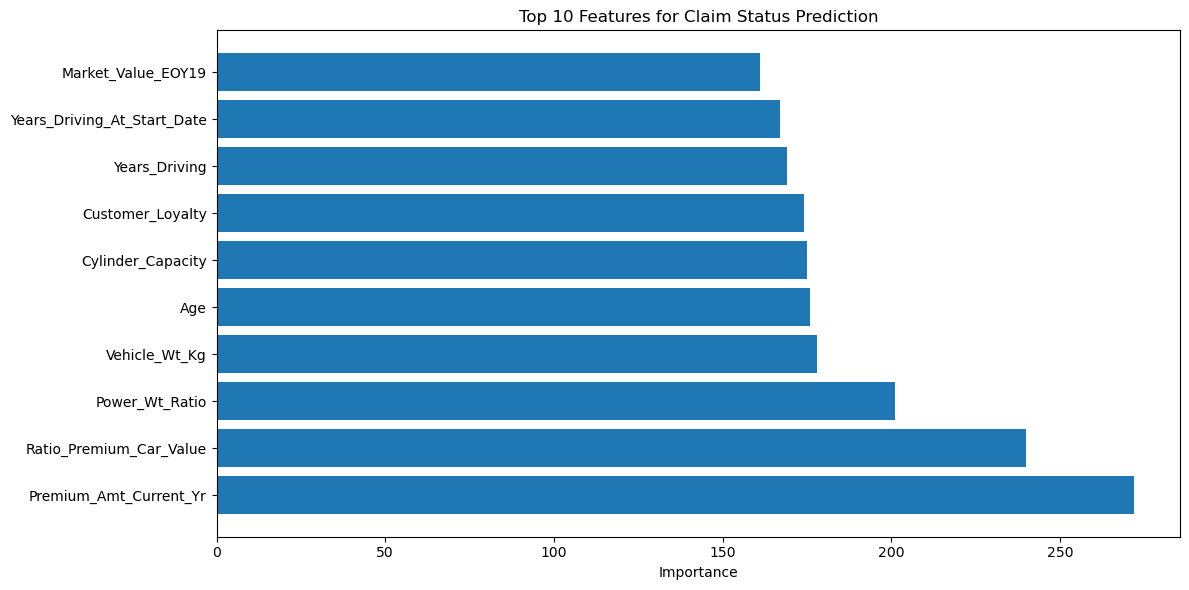

In [39]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_cs = pd.DataFrame({'feature': X_cs_selected.columns, 'importance': lgb.LGBMClassifier().fit(X_cs_selected, y_cs_train).feature_importances_})
importance_cs = importance_cs.sort_values('importance', ascending=False).head(10)
plt.barh(importance_cs['feature'], importance_cs['importance'])
plt.title('Top 10 Features for Claim Status Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2376
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 30
[LightGBM] [Info] Start training from score 69.439712


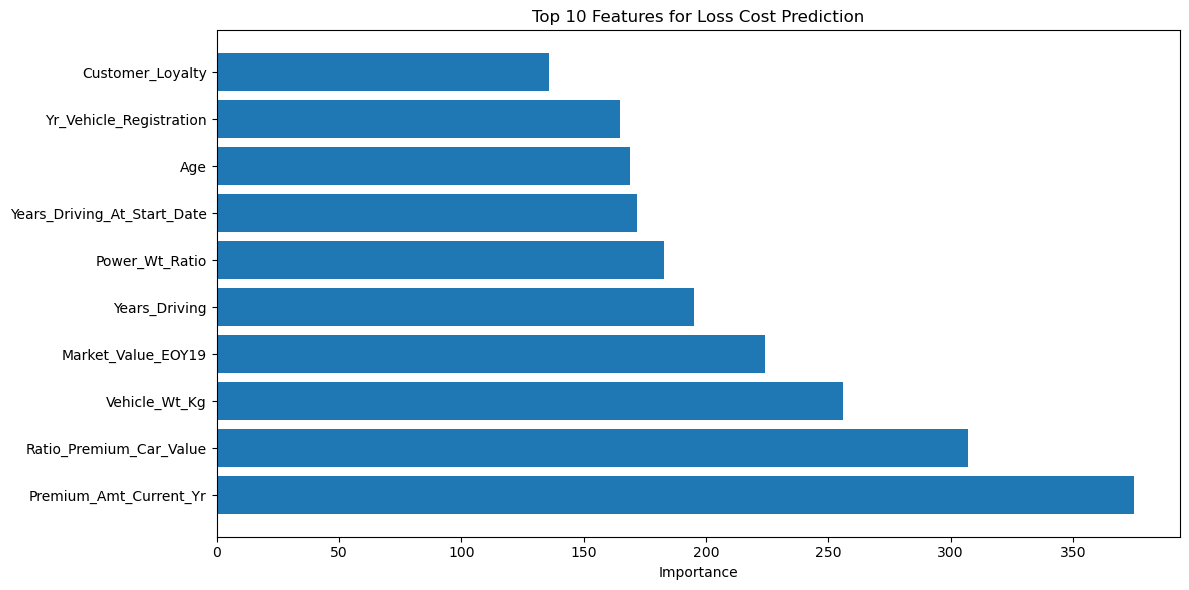

In [40]:
# Also plot for Loss Cost
plt.figure(figsize=(12, 6))
importance_lc = pd.DataFrame({'feature': X_lc_selected.columns, 'importance': lgb.LGBMRegressor().fit(X_lc_selected, y_lc_train).feature_importances_})
importance_lc = importance_lc.sort_values('importance', ascending=False).head(10)
plt.barh(importance_lc['feature'], importance_lc['importance'])
plt.title('Top 10 Features for Loss Cost Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 30
[LightGBM] [Info] Start training from score 129.973358


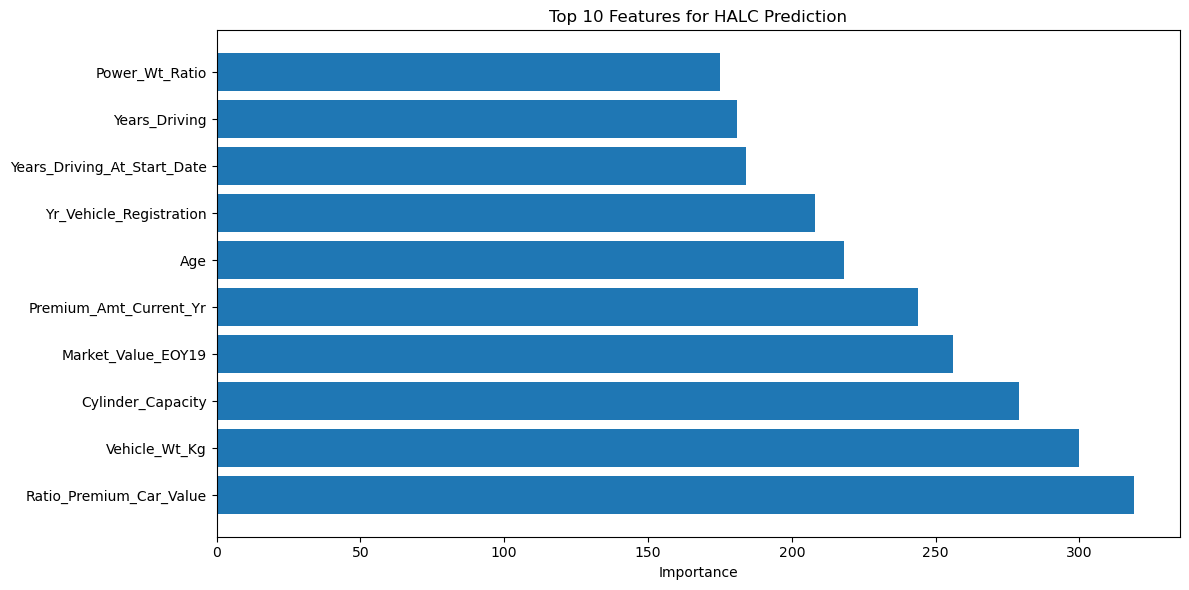

In [41]:
# Plot for HALC
plt.figure(figsize=(12, 6))
importance_halc = pd.DataFrame({'feature': X_halc_selected.columns, 'importance': lgb.LGBMRegressor().fit(X_halc_selected, y_halc_train).feature_importances_})
importance_halc = importance_halc.sort_values('importance', ascending=False).head(10)
plt.barh(importance_halc['feature'], importance_halc['importance'])
plt.title('Top 10 Features for HALC Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Target Distribution Analysis

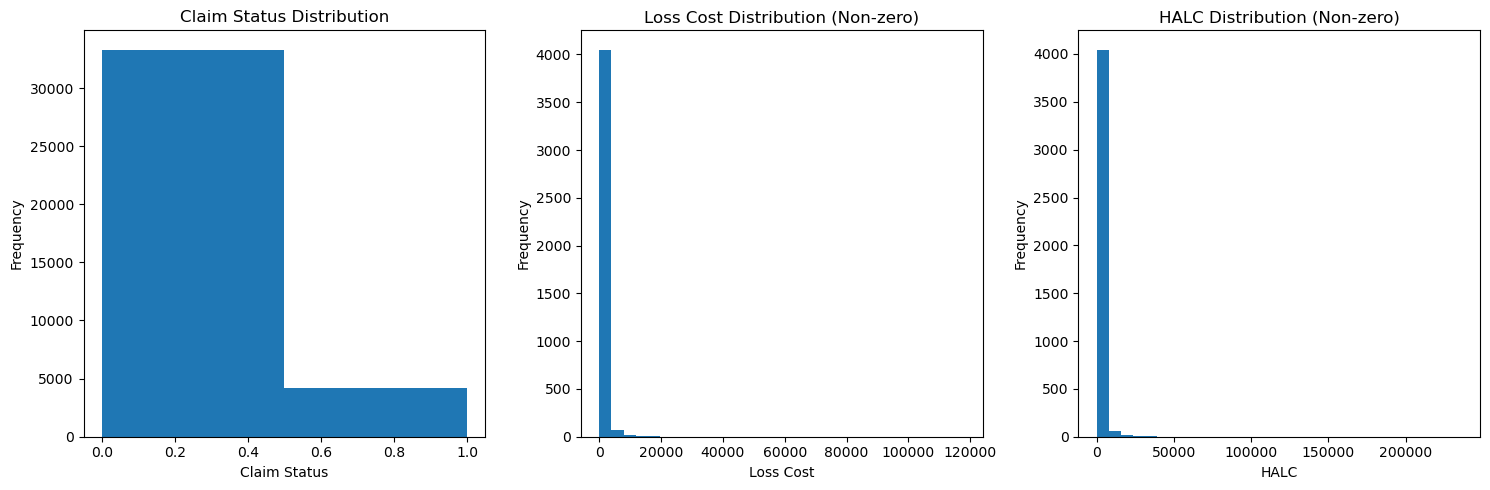

In [42]:
# Distribution of target variables
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(Y_CS, bins=2)
plt.title('Claim Status Distribution')
plt.xlabel('Claim Status')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(Y_LC[Y_LC > 0], bins=30)
plt.title('Loss Cost Distribution (Non-zero)')
plt.xlabel('Loss Cost')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(Y_HALC[Y_HALC > 0], bins=30)
plt.title('HALC Distribution (Non-zero)')
plt.xlabel('HALC')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

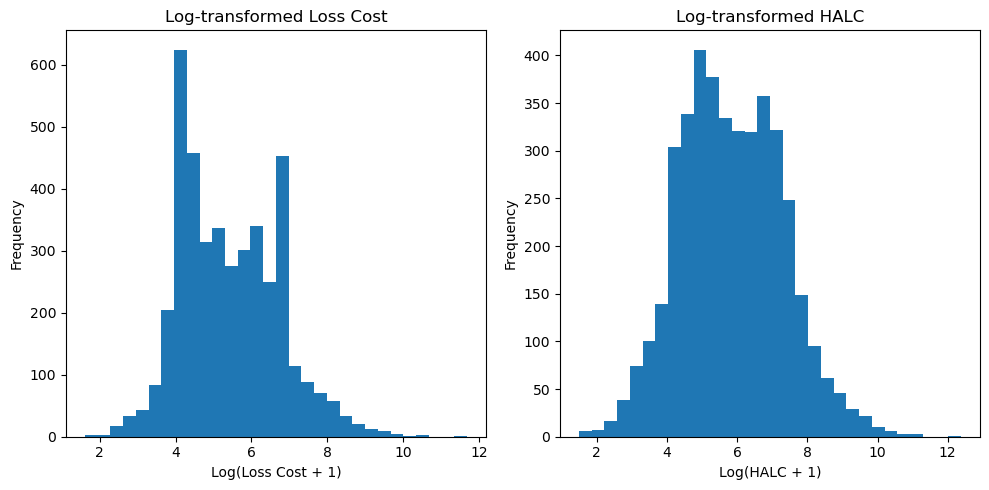

## Hyperparameter setup

Preparing data for hyperparameter tuning...
